In [1]:
from Functions.data_analysis import *
from Functions.edit_database import getTransactionData, getAccount
from Functions.variables import typeMapping
import numpy as np
from scipy.stats import linregress

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [2]:
myAcc = getAccount("atlas")

myAcc.summary()

       Username: atlas
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-07-28 13:26:37
   Date Updated: 2024-07-28 13:26:37
        Balance: 10000000


In [3]:
df = getTransactionData(myAcc)

In [4]:
def enrichData(df: pd.DataFrame) -> pd.DataFrame:

    def WoM(dt):
        """ Returns the week of the month for the specified date. """
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        
        return int(np.ceil(adjusted_dom / 7.0))

    df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
    df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
    
    
    expenses = pd.concat([
        df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
    ], axis=1)

    
    revenue = pd.concat([
        df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
    ], axis=1)

    expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
    revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


    expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
    revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

    expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
    revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


    features = pd.DataFrame(index=expenses.index.union(revenue.index))
    features[("Features", "DoW")] = features.index.day_of_week
    features[("Features", "DoM")] = features.index.day
    features[("Features", "WoM")] = features.index.map(WoM)
    features[("Features", "DAY")] = features.index.day_of_year
    features[("Features", "WEEK")] = features.index.isocalendar().week
    features[("Features", "QUARTER")] = features.index.quarter
    features[("Features", "MONTH")] = features.index.month
    features[("Features", "YEAR")] = features.index.year

    DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
    
    DATA.index.name = "DATE"
    DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

    # print(len(expenses), len(revenue))

    
    return DATA


In [5]:
enrichData(df)

Expenses                                           Revenue       \
                  0      1         2    3    4    5     TOTAL      10   11   
DATE                                                                         
2000-01-01   133000  20000   15000.0  0.0  0.0  0.0  168000.0     0.0  0.0   
2000-01-02    80000      0       0.0  0.0  0.0  0.0   80000.0     0.0  0.0   
2000-01-03    47000  35000  150000.0  0.0  0.0  0.0  232000.0     0.0  0.0   
2000-01-04   140000      0       0.0  0.0  0.0  0.0  140000.0     0.0  0.0   
2000-01-05   127000   5000       0.0  0.0  0.0  0.0  132000.0     0.0  0.0   
...             ...    ...       ...  ...  ...  ...       ...     ...  ...   
2023-12-26   139000      0       0.0  0.0  0.0  0.0  139000.0     0.0  0.0   
2023-12-27   106000      0       0.0  0.0  0.0  0.0  106000.0     0.0  0.0   
2023-12-28    84000  50000       0.0  0.0  0.0  0.0  134000.0     0.0  0.0   
2023-12-29    64000  30000       0.0  0.0  0.0  0.0   94000.0     0.0  0.0   
2023-12-30   206000  45000       0.0  0.0  0.0  0.0  251000.0     0.0  0.0   

                 ...       Features                                        \
             12  ... TOTAL      DoW DoM WoM  DAY WEEK QUARTER MONTH  YEAR   
DATE             ...                                                        
2000-01-01  0.0  ...   0.0        5   1   1    1   52       1     1  2000   
2000-01-02  0.0  ...   0.0        6   2   1    2   52       1     1  2000   
2000-01-03  0.0  ...   0.0        0   3   2    3    1       1     1  2000   
2000-01-04  0.0  ...   0.0        1   4   2    4    1       1     1  2000   
2000-01-05  0.0  ...   0.0        2   5   2    5    1       1     1  2000   
...         ...  ...   ...      ...  ..  ..  ...  ...     ...   ...   ...   
2023-12-26  0.0  ...   0.0        1  26   5  360   52       4    12  2023   
2023-12-27  0.0  ...   0.0        2  27   5  361   52       4    12  2023   
2023-12-28  0.0  ...   0.0        3  28   5  362   52       4    12  2023   
2023-12-29  0.0  ...   0.0        4  29   5  363   52       4    12  2023   
2023-12-30  0.0  ...   0.0        5  30   5  364   52       4    12  2023   

               TOTAL  
                      
DATE                  
2000-01-01 -168000.0  
2000-01-02  -80000.0  
2000-01-03 -232000.0  
2000-01-04 -140000.0  
2000-01-05 -132000.0  
...              ...  
2023-12-26 -139000.0  
2023-12-27 -106000.0  
2023-12-28 -134000.0  
2023-12-29  -94000.0  
2023-12-30 -251000.0  

[8765 rows x 21 columns]

In [6]:
def graphData(df: pd.DataFrame, index: str, group: str, displacement: int = 0) -> plt.Figure:
    if index not in ["DAY", "WEEK", "MONTH", "QUARTER", "YEAR"]:
        raise ValueError("Invalid index. Allowed values are 'DAY', 'WEEK', 'MONTH', 'QUARTER', 'YEAR'.")
    
    if group not in ["DAY", "WEEK", "MONTH", "YEAR"]:
        raise ValueError("Invalid group. Allowed values are 'DAY', 'WEEK', 'MONTH', 'YEAR'.")
    
    if displacement < 0:
        raise ValueError("Invalid displacement, must be greater than or equal to 0")
    
    if index == "DAY" and group not in ["WEEK", "MONTH", "YEAR"]:
        raise ValueError("Index is not in range.")
    elif index == "WEEK" and group not in ["MONTH", "YEAR"]:
        raise ValueError("Index is not in range.")
    elif index == "MONTH" and group not in ["YEAR"]:
        raise ValueError("Index is not in range.")
    elif index == "QUARTER" and group not in ["YEAR"]:
        raise ValueError("Index is not in range.")
    
    if index == "YEAR": group == "YEAR"
    
    last_data = df.iloc[-1]
    DATA = df
    if index != "YEAR":
        df = df[df[('Features', group)] == last_data[('Features', group)] - displacement]
        DATA = df[df[('Features', 'YEAR')] == last_data[('Features', 'YEAR')] - (displacement if group == "YEAR" else 0)]
    DATA = DATA.groupby(('Features', index)).sum()
    DATA.index.name = index

    def MAE(x, m, b, actual):
        return np.mean(abs(actual - (m * x + b)))

    # Bar Graph: Revenue & Expenses
    bar_graph1, ax1 = plt.subplots(figsize=(20, 6))
    DATA['Revenue', 'TOTAL'].plot(kind='bar', ax=ax1, label='Total Revenue', color='green', alpha=0.6)
    (-DATA['Expenses', 'TOTAL']).plot(kind='bar', ax=ax1, label='Total Expenses', color='red', alpha=0.6)
    ax1.set_title(f'Total Expenses and Revenue\n{group} {int(last_data[("Features", group)] - displacement)}', loc='center')
    ax1.set_xlabel(index)
    ax1.set_ylabel('Amount')
    ax1.legend()
    plt.tight_layout()

    # Bar Graph: Total
    bar_graph2, ax2 = plt.subplots(figsize=(20, 6))
    DATA['TOTAL'].plot(kind='bar', ax=ax2, label='Net Total', color='blue', alpha=0.6)
    DATA['TOTAL'].plot(color='red', label='TOTAL')
    ax2.set_title(f'Net Total\n{group} {int(last_data[("Features", group)] - displacement)}', loc='center')
    ax2.set_xlabel(index)
    ax2.set_ylabel('Amount')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # Cumulative
    cum_graph, ax3 = plt.subplots(figsize=(20, 6))
    DATA['Revenue', 'TOTAL'].cumsum().plot(ax=ax3, label='Cumulative Revenue', color='green', alpha=0.6)
    DATA['Expenses', 'TOTAL'].cumsum().plot(ax=ax3, label='Cumulative Expenses', color='red', alpha=0.6)
    DATA['TOTAL'].cumsum().plot(ax=ax3, label='Budget', color='blue', alpha=0.6)
    ax3.set_title(f'Cumulative Data\n{group} {int(last_data[("Features", group)] - displacement)}', loc='center')
    ax3.set_xlabel(index)
    ax3.set_ylabel('Amount')
    ax3.legend()
    plt.tight_layout()

    # Expenses LinReg
    expenses_linreg, ax4 = plt.subplots(figsize=(20, 6))
    DATA['Expenses', 'TOTAL'].cumsum().plot(ax=ax4, label='Cumulative Revenue', color='green', alpha=0.6)

    x = np.arange(len(DATA['Expenses', 'TOTAL'].cumsum())) + df.iloc[2]['Features', index]
    m, b = np.polyfit(x, np.array(DATA['Expenses', 'TOTAL'].cumsum()), 1)
    y_actual = np.array(DATA['Expenses', 'TOTAL'].cumsum())

    ax4.plot(x, m * x + b, label=f'Linear Regression')
    ax4.set_title(f'Cumulative Expenses\n{group} {int(last_data[("Features", group)] - displacement)}', loc='center')
    ax4.set_xlabel(index)
    ax4.set_ylabel('Amount')
    ax4.legend()
    ax4.text(
        x[int(len(x)/2)], m * x[int(len(x)/2)] + b - 0.3 * (max(y_actual) - min(y_actual)), 
        f"MAE: {MAE(x, m, b, np.array(DATA['Expenses', 'TOTAL'].cumsum())):.0f}\nf(t) = {m:.0f}x + {b:.0f}\nRp. {m:.0f}/{index.lower()}", 
        fontsize=12, verticalalignment='bottom', horizontalalignment='left'
    )
    plt.tight_layout()

    # Revenue LinReg
    revenue_linreg, ax5 = plt.subplots(figsize=(20, 6))
    DATA['Revenue', 'TOTAL'].cumsum().plot(ax=ax5, label='Cumulative Revenue', color='green', alpha=0.6)

    x = np.arange(len(DATA['Revenue', 'TOTAL'].cumsum())) + df.iloc[2]['Features', index]
    m, b = np.polyfit(x, np.array(DATA['Revenue', 'TOTAL'].cumsum()), 1)
    y_actual = np.array(DATA['Revenue', 'TOTAL'].cumsum())

    ax5.plot(x, m * x + b, label=f'Linear Regression')
    ax5.set_title(f'Cumulative Revenue\n{group} {int(last_data[("Features", group)] - displacement)}', loc='center')
    ax5.set_xlabel(index)
    ax5.set_ylabel('Amount')
    ax5.legend()
    ax5.text(
        x[int(len(x)/2)], m * x[int(len(x)/2)] + b - 0.3 * (max(y_actual) - min(y_actual)), 
        f"MAE: {MAE(x, m, b, np.array(DATA['Revenue', 'TOTAL'].cumsum())):.0f}\nf(t) = {m:.0f}x + {b:.0f}\nRp. {m:.0f}/{index.lower()}", 
        fontsize=12, verticalalignment='bottom', horizontalalignment='left'
    )
    plt.tight_layout()

    return {
        "Bar Graph 1": bar_graph1,
        "Bar Graph 2": bar_graph2,
        "Cumulative Graph": cum_graph,
        "Revenue LinReg": revenue_linreg,
        "Expenses LinReg": expenses_linreg
    }

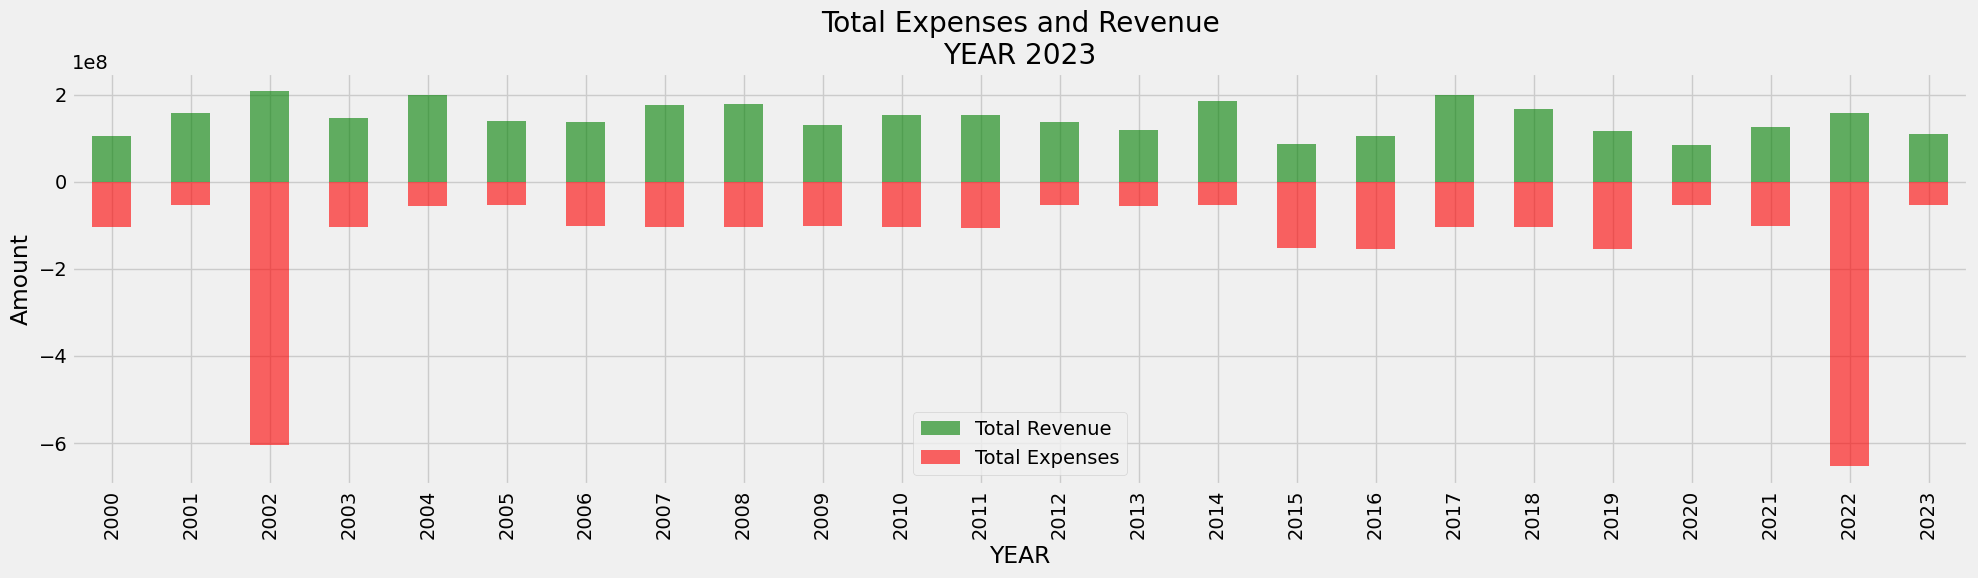

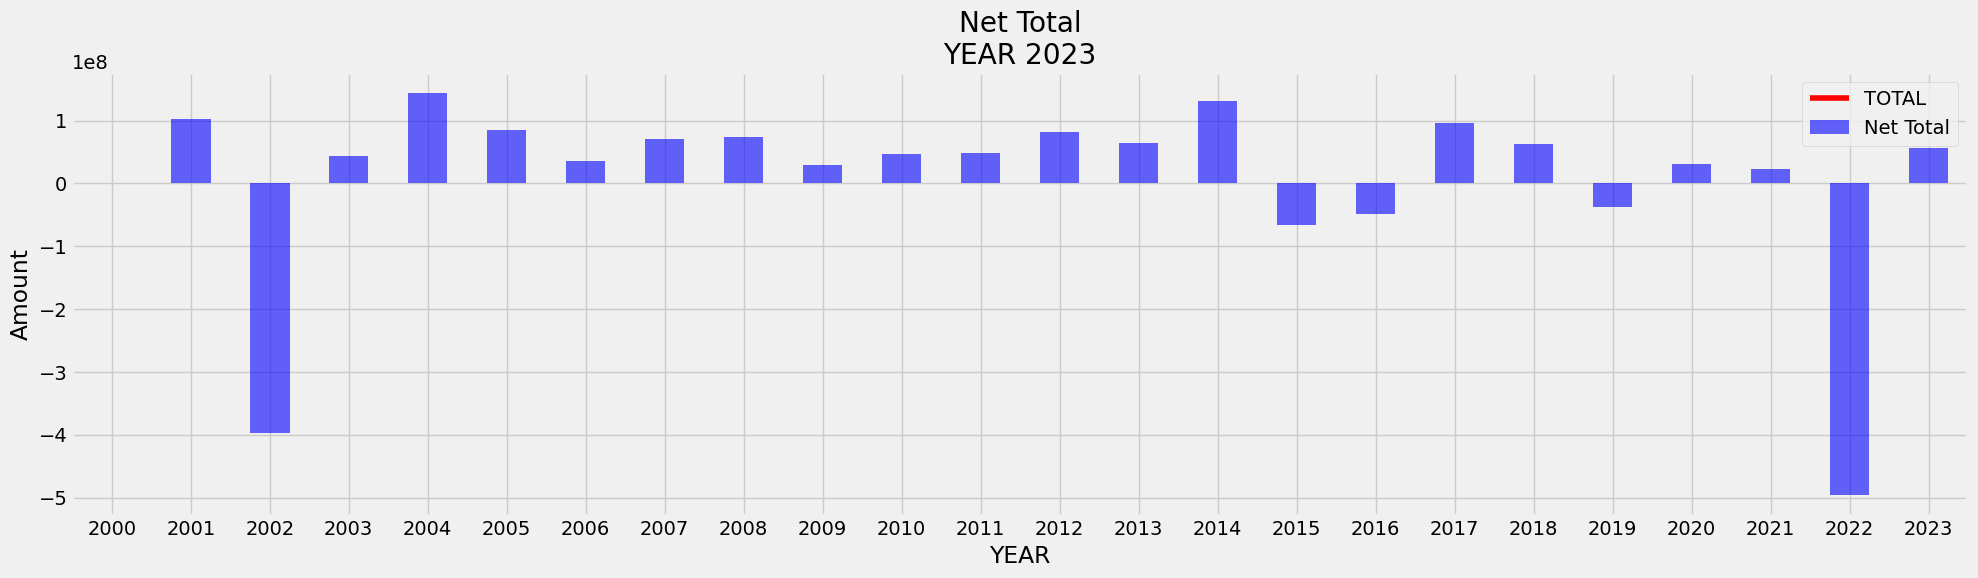

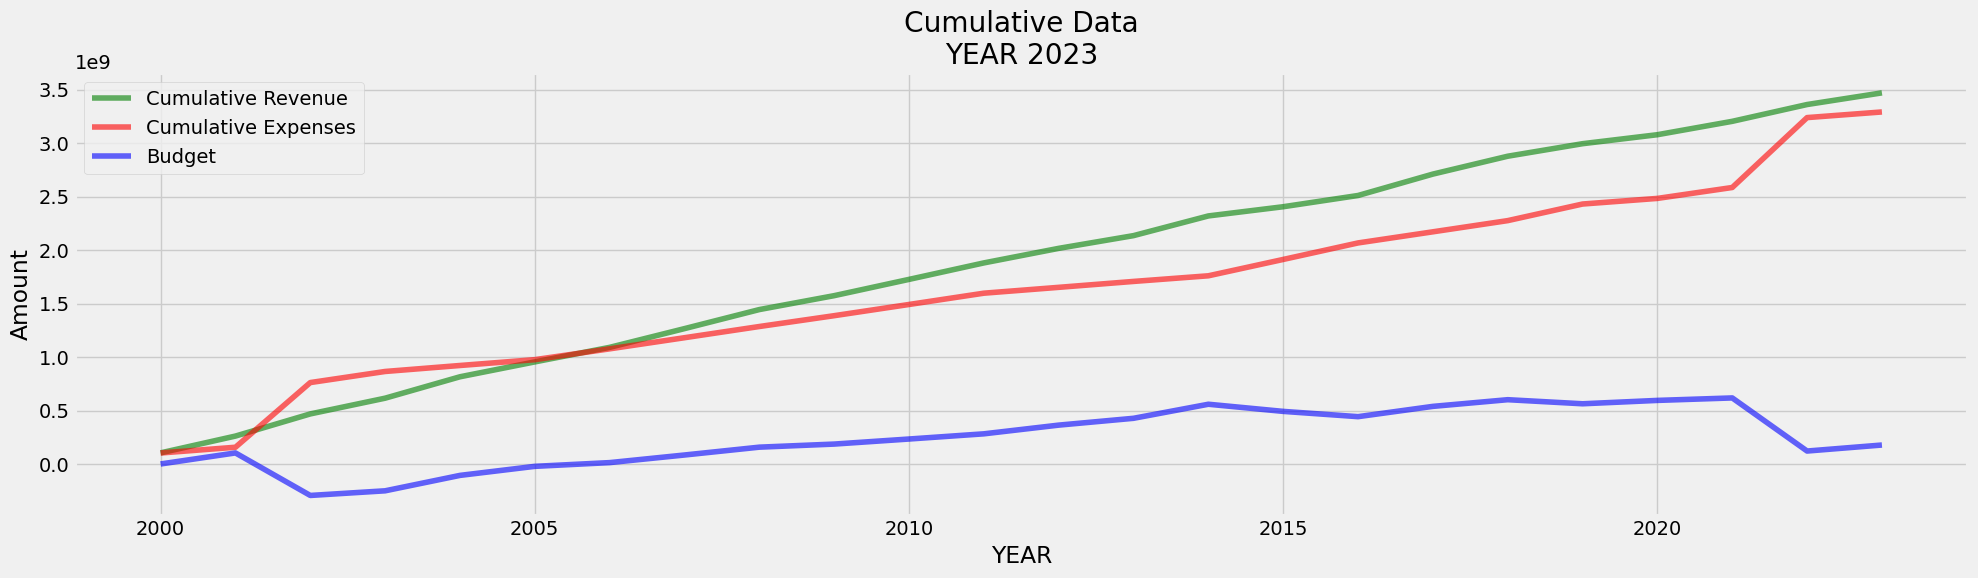

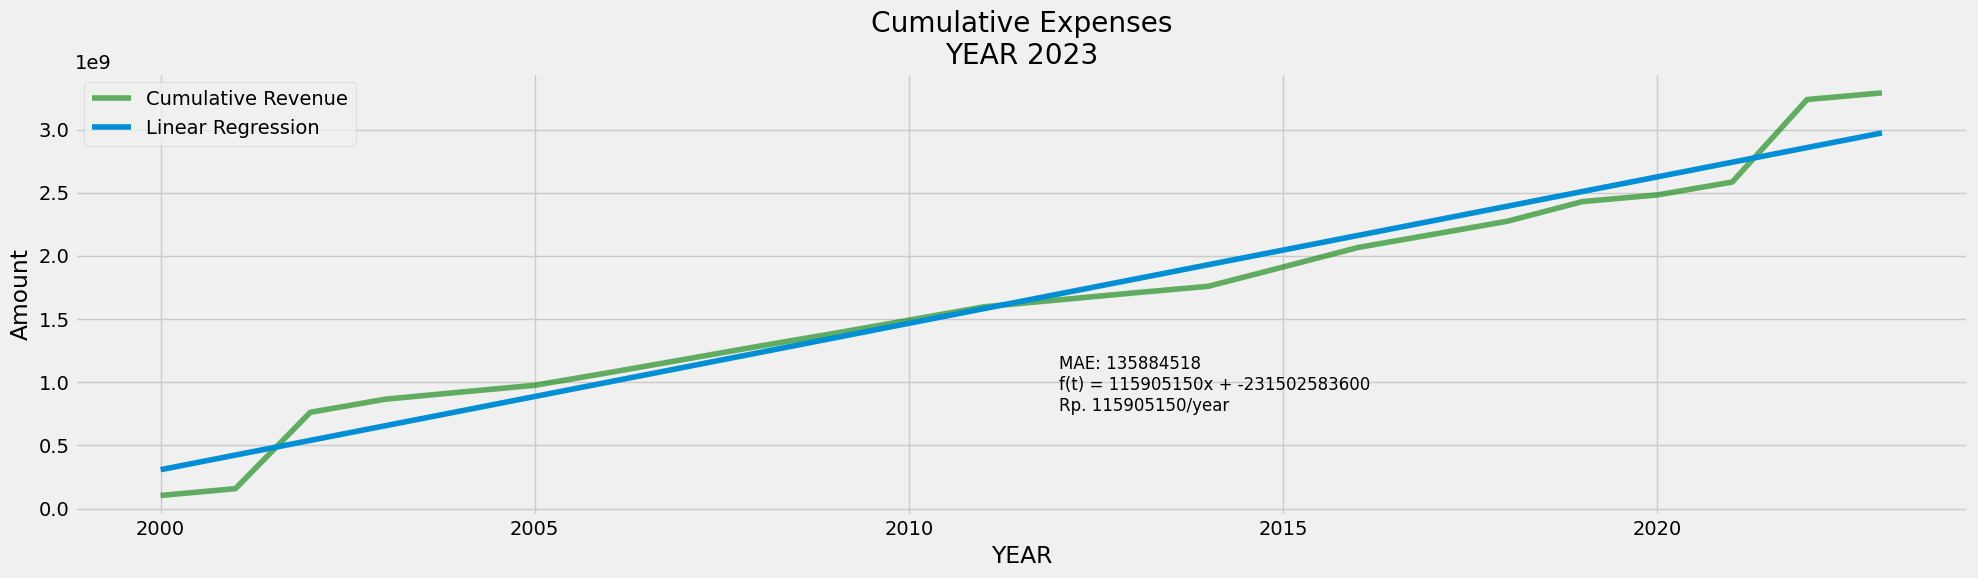

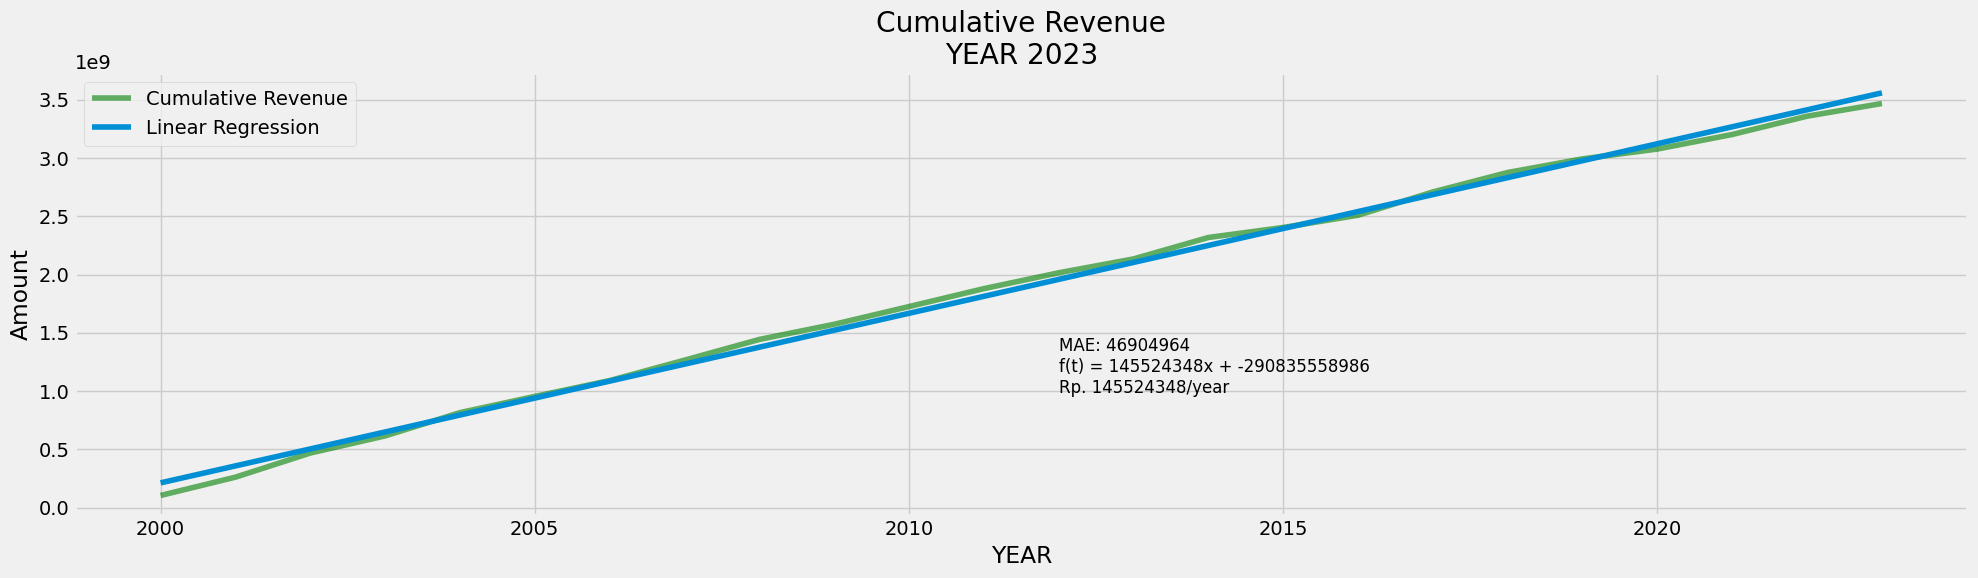

In [7]:
graphs = graphData(
    df = enrichData(df), 
    index = "YEAR", 
    group = "YEAR",
    displacement = 0
)

# plt.figure(graphs["Bar Graph 1"].number)
# plt.show()